In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import copy
from torchvision import models
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from deepctr_torch.layers.interaction import CrossNet
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from tableone import TableOne
from sklearn.model_selection import train_test_split
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
import warnings
warnings.filterwarnings("ignore")

2022-05-18 11:16:11.688148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/slurm-20.11.0/lib64:
2022-05-18 11:16:11.688206: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
path = '/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/'
items = pd.read_csv(path+'1.0/icu/d_items.csv')
df_timeseries= pd.read_csv(path + '1.0/small/dataset_sequential.csv', parse_dates = ['charttime', 'obs_window_start', 'obs_window_end'])

In [3]:
df_timeseries['window'] = np.nan
##put data into windows
date_windows = [
     df_timeseries['charttime'] <= df_timeseries['obs_window_start'] + timedelta(days = 3),
     (df_timeseries['charttime'] > df_timeseries['obs_window_start'] + timedelta(days = 3)) &
        (df_timeseries['charttime'] <= df_timeseries['obs_window_start'] + timedelta(days = 3.5)),
     (df_timeseries['charttime'] > df_timeseries['obs_window_start'] + timedelta(days = 3.5)) &
        (df_timeseries['charttime'] <= df_timeseries['obs_window_start'] + timedelta(days = 4)),
     (df_timeseries['charttime'] > df_timeseries['obs_window_start'] + timedelta(days = 4)) &
        (df_timeseries['charttime'] <= df_timeseries['obs_window_start'] + timedelta(days = 4.5))]

values = [0,1,2,3]

df_timeseries['window'] = np.select(date_windows, values)

In [9]:
#filter itemids with good coverage
df_window = df_timeseries[(df_timeseries['window'] == 2) & (df_timeseries['hadm_id'].isin(hadm_ids))]
df_pivot = df_window.pivot_table(index = 'hadm_id', columns = 'itemid', values = 'valuenum', aggfunc = 'mean')
consistent_itemids = list(df_pivot.columns[df_pivot.notna().sum(axis =0) / df_pivot.shape[0] >0.7])

In [11]:
itemids = [220045, 220179, 220180, 220210, 220277, 220739, 223900, 223901]
items[items['itemid'].isin(itemids)]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
1,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
22,220179,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
23,220180,Non Invasive Blood Pressure diastolic,NBPd,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
26,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,NaN,NaN
33,220277,O2 saturation pulseoxymetry,SpO2,chartevents,Respiratory,%,Numeric,NaN,NaN
63,220739,GCS - Eye Opening,Eye Opening,chartevents,Neurological,NaN,Text,NaN,NaN
285,223900,GCS - Verbal Response,Verbal Response,chartevents,Neurological,NaN,Text,NaN,NaN
286,223901,GCS - Motor Response,Motor Response,chartevents,Neurological,NaN,Text,NaN,NaN


In [12]:
df_timeseries = df_timeseries[df_timeseries['itemid'].isin(itemids)]
df_timeseries.head()

,subject_id,hadm_id,charttime,itemid,value,valuenum,valueuom,obs_window_start,obs_window_end,outcome,window
0,10017851,23415994,2115-11-01 20:40:00,220045,93.0,93.0,bpm,2115-11-01 08:39:57,2115-11-05 20:39:57,0,0
1,10017851,23415994,2115-11-01 20:40:00,220210,24.0,24.0,insp/min,2115-11-01 08:39:57,2115-11-05 20:39:57,0,0
2,10017851,23415994,2115-11-01 20:40:00,220277,97.0,97.0,%,2115-11-01 08:39:57,2115-11-05 20:39:57,0,0
3,10017851,23415994,2115-11-01 20:43:00,220179,107.0,107.0,mmHg,2115-11-01 08:39:57,2115-11-05 20:39:57,0,0
4,10017851,23415994,2115-11-01 20:43:00,220180,55.0,55.0,mmHg,2115-11-01 08:39:57,2115-11-05 20:39:57,0,0


In [13]:
#find hadmids with records across all windows
hadm_ids = list(set.intersection(*list(map(set,df_timeseries.groupby('window')['hadm_id'].unique()))))

In [16]:
#impute missing data
imputer = MissForest()

In [388]:
np.array(df_pivot).shape

(4068, 8)

In [392]:
def gcs_binarisation(df):
    df = pd.DataFrame(df, columns = df_pivot.columns, index = df_pivot.index)
    ##sum gcs
    gcs = [223900,223901,220739]
    df['gcs'] = df.loc[:,gcs[0]] + df.loc[:,gcs[1]] + df.loc[:,gcs[2]]
    df_gcs = df.drop(columns = gcs)
    
    ##bucket gcs
    bins = [0,5,8,12,15]
    labels = [0,1,2,3]
    df_gcs['gcs_cat'] = pd.cut(df_gcs['gcs'], bins, labels = labels)
    df_gcs.drop('gcs', axis = 1, inplace = True)
    df_gcs = pd.get_dummies(df_gcs, columns = ['gcs_cat'], drop_first = True)
    df_gcs = df_gcs.rename(columns = {'gcs_cat_1': 'gcs_5-8', 'gcs_cat_2': 'gcs_9-12','gcs_cat_3': 'gcs_13-15'})
    return np.array(df_gcs)

In [396]:
tensor = torch.zeros(len(hadm_ids),8,1, dtype=torch.int32)
for i in range(4):
    df_window = df_timeseries[(df_timeseries['window'] == i) & (df_timeseries['hadm_id'].isin(hadm_ids))]
    df_pivot = df_window.pivot_table(index = 'hadm_id', columns = 'itemid', values = 'valuenum', aggfunc = 'mean')
    df_pivot = df_pivot.loc[hadm_ids]
    df_imputed = imputer.fit_transform(df_pivot)
    df_imputed = gcs_binarisation(df_imputed)
    df_tensor = Variable(torch.Tensor(df_imputed))
    tensor = torch.cat((tensor, df_tensor.unsqueeze(-1).expand(len(hadm_ids),8,1)),2)
tensor = tensor[:,:,1:]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [180]:
##get the outcomes for the dataset
outcomes = df_timeseries[df_timeseries['hadm_id'].isin(hadm_ids)].groupby('hadm_id')['outcome'].first()
outcomes = outcomes.loc[hadm_ids]
y_tensor = Variable(torch.Tensor(outcomes.values))

In [463]:
def tensorScaler(train, test):
    mean = train.mean(0, keepdim=True)[:,:,:5]
    std = train.std(0, unbiased=False, keepdim=True)[:,:,:5]
    ##apply to train and test set
    train_s = train[:,:,:5] - mean
    train_s /= std
    train_s = torch.cat((train_s, train[:,:,5:]), dim = 2)
    test_s = test[:,:,:5] - mean
    test_s /= std
    test_s = torch.cat((test_s, test[:,:,5:]), dim = 2)
    return train_s, test_s

In [470]:
tensor_lstm = torch.transpose(tensor, 1, 2) #reshape 
##create train and test set
train_size = int(0.8 * len(tensor_lstm))
test_size = len(tensor_lstm) - train_size
train_ind, test_ind = torch.utils.data.random_split(tensor_lstm, [train_size, test_size],
                                                            generator=torch.Generator().manual_seed(42))

train_dataset, test_dataset = tensor_lstm[train_ind.indices], tensor_lstm[test_ind.indices]
train_y, test_y = y_tensor[train_ind.indices], y_tensor[test_ind.indices]

train_dataset, test_dataset = tensorScaler(train_dataset, test_dataset)

In [488]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 32) #fully connected 1
        self.fc_2 =  nn.Linear(32, 12) #fully connected 1
        self.fc_3 = nn.Linear(12, 1)
        self.fc = nn.Sigmoid() #fully connected last layer

        self.relu = nn.ReLU()
    def forward(self,x):
            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
            c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
            # Propagate input through LSTM
            output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
            out = output[:,-1,:] #reshaping the data for Dense layer next
            out = self.relu(out)
            out = self.fc_1(out) #first Dense
            out = self.relu(out) #relu
            out = self.fc_2(out) #2nd dense
            out = self.relu(out) #relu
            out = self.fc_3(out) #3rd dense
            out = self.relu(out) #relu
            out = self.fc(out) #Final Output
            return out

In [511]:
num_epochs = 1001 #1000 epochs
learning_rate = 0.0001 #0.001 lr
input_size = 8 #number of features
hidden_size = 5 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, 4) #our lstm class 

criterion = torch.nn.BCELoss() 
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 
best_AUC = 0

In [514]:
learning_rate = 0.00001
for epoch in range(num_epochs):
    outputs = lstm1.forward(train_dataset) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs.squeeze(),train_y)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
        fpr, tpr, thresholds = metrics.roc_curve(train_y.detach().numpy(), outputs.detach().numpy())
        AUC = metrics.auc(fpr, tpr)
        print('Train:', AUC)
        
        with torch.no_grad():
            outputs = lstm1.forward(test_dataset)
            loss = criterion(outputs.squeeze(), test_y)

            #calculate AUC for best epoch
            fpr, tpr, thresholds = metrics.roc_curve(test_y.detach().numpy(), outputs.detach().numpy())
            AUC = metrics.auc(fpr, tpr)
            if AUC > best_AUC:
                best_AUC = AUC
                fpr_best, tpr_best, thresholds_best = fpr, tpr, thresholds
                
            print('Test:', AUC)

Epoch: 0, loss: 0.58224
Train: 0.7712389910049656
Test: 0.7626224064378515
Epoch: 100, loss: 0.58062
Train: 0.771331774072851
Test: 0.7612104905953074
Epoch: 200, loss: 0.57919
Train: 0.7721528095470368
Test: 0.7610589974791546
Epoch: 300, loss: 0.57782
Train: 0.7725216695801812
Test: 0.7585745103742486
Epoch: 400, loss: 0.57656
Train: 0.772378518561158
Test: 0.7578806719022688
Epoch: 500, loss: 0.57535
Train: 0.7729761172596199
Test: 0.757132295908474
Epoch: 600, loss: 0.57427
Train: 0.7741099642198194
Test: 0.7573625654450262
Epoch: 700, loss: 0.57318
Train: 0.774971710631955
Test: 0.7574686106263333
Epoch: 800, loss: 0.57197
Train: 0.7753848793138446
Test: 0.7581079115764979
Epoch: 900, loss: 0.57076
Train: 0.7756005526083781
Test: 0.759247139809967
Epoch: 1000, loss: 0.56971
Train: 0.776220116278013
Test: 0.7583200019391119


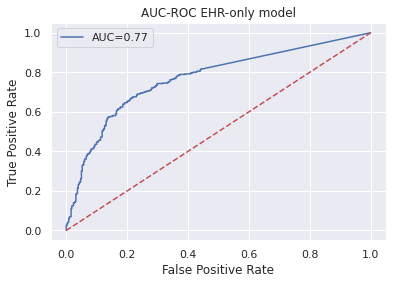

In [519]:
##plot results
sns.set_theme()
plt.plot(fpr_best,tpr_best, label="AUC="+str(round(best_AUC,2)))
plt.plot([0,1],[0,1], linestyle = '--', color = 'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.title('AUC-ROC EHR-only model')
plt.show()

## NN

In [446]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size[0])
            self.relu1 = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size[0], self.hidden_size[1])
            self.relu2 = torch.nn.ReLU()
            self.fc3 = torch.nn.Linear(self.hidden_size[1], self.hidden_size[2])
            self.relu3 = torch.nn.ReLU()
            self.fc4 = torch.nn.Linear(self.hidden_size[2], 1)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu1(hidden)
            relu = self.dropout(relu)
            hidden = self.fc2(relu)
            relu = self.relu2(hidden)
            relu = self.dropout(relu)
            hidden = self.fc3(relu)
            relu = self.relu3(hidden)
            relu = self.dropout(relu)
            output = self.fc4(relu)
            output = self.sigmoid(output)
            return output

In [449]:
train_dataset_nn, test_dataset_nn = train_dataset[:,-1,:], test_dataset[:,-1,:]
train_y_nn, test_y_nn = y_tensor[train_ind.indices], y_tensor[test_ind.indices]

In [450]:
## initialize model
model = Feedforward(train_dataset_nn.shape[1], [32,24,12])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0005)

## of steps to take
total_step = train_dataset_nn.shape[0]

num_epochs = 1000

In [451]:
for epoch in range(num_epochs):
    outputs = model(train_dataset_nn) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs.squeeze(),train_y_nn)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
        fpr, tpr, thresholds = metrics.roc_curve(train_y_nn.detach().numpy(), outputs.detach().numpy())
        AUC = metrics.auc(fpr, tpr)
        print('Train:', AUC)
        
        with torch.no_grad():
            outputs = model(test_dataset_nn)
            loss = criterion(outputs.squeeze(), test_y_nn)

            #calculate AUC for best epoch
            fpr, tpr, thresholds = metrics.roc_curve(test_y_nn.detach().numpy(), outputs.detach().numpy())
            AUC = metrics.auc(fpr, tpr)
            print('Test:', AUC)

Epoch: 0, loss: 0.69198
Train: 0.5162129890235738
Test: 0.49671865910413027
Epoch: 100, loss: 0.62369
Train: 0.7106588430973941
Test: 0.6971470816366104
Epoch: 200, loss: 0.58151
Train: 0.7597338905871767
Test: 0.7413891312778748
Epoch: 300, loss: 0.58244
Train: 0.7623503731015447
Test: 0.7337962962962963
Epoch: 400, loss: 0.57521
Train: 0.7679292864262537
Test: 0.7608832654644173
Epoch: 500, loss: 0.56205
Train: 0.7767569325993499
Test: 0.7722573686251697
Epoch: 600, loss: 0.56437
Train: 0.7786775421045775
Test: 0.7537691487298818
Epoch: 700, loss: 0.56275
Train: 0.7719666753516667
Test: 0.7574777002133024
Epoch: 800, loss: 0.57034
Train: 0.774144994561776
Test: 0.7489092495636998
Epoch: 900, loss: 0.55683
Train: 0.7807038106952747
Test: 0.7697789412449099


## RF check

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [505]:
train_dataset_rf, test_dataset_rf = train_dataset[:,-1,:], test_dataset[:,-1,:]
train_y_rf, test_y_rf = y_tensor[train_ind.indices], y_tensor[test_ind.indices]

In [506]:
clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(train_dataset_rf, train_y_rf)
fpr, tpr, thresholds = metrics.roc_curve(test_y_rf, clf.predict_proba(test_dataset_rf)[:,1])
AUC = metrics.auc(fpr, tpr)
AUC

0.7805652511149892